```
/*
 * THIS IS SAMPLE CODE
 *
 * Copyright 2020 Google
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 * http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
 ```

In [ ]:
%pip install pytorch
%pip install PyMuPDF
%pip install ftfy
%pip install transformers
%pip install bert-extractive-summarizer==0.4.2
%pip install tensorflow-hub
%pip install seaborn

In [1]:
# HuggingFace's transformer library using BERT on pytorch
import torch
from transformers import *

# Load model, model config and tokenizer for SciBert
custom_config = AutoConfig.from_pretrained('allenai/scibert_scivocab_uncased')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
custom_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', config=custom_config)

# HuggingFace's summarizer
from summarizer import Summarizer

In [2]:
#Pymupdf library
import fitz  

In [3]:
# utility to fix utf-encoded text
from ftfy import fix_text

In [4]:
# requirements for semantic search with TF sentence encoder
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

## Find and highlight words 

In [5]:
# file name
fname = 'top2vec.pdf'
# words to search
word_list = ['topic', 'vector', 'semantic', 'transformer'] 

In [11]:
def mark_word(page, text):
    """Underline each word that contains 'text'.
    """
    found = 0
    wlist = page.getTextWords()        # make the word list
    for w in wlist:                    # scan through all words on page
        if text in w[4]:               # w[4] is the word's string
            found += 1                 # count
            r = fitz.Rect(w[:4])       # make rect from word bbox
            page.addUnderlineAnnot(r)  # underline
    return found

In [12]:
doc = fitz.open(fname)

In [13]:
new_doc = False                        # indicator if anything found at all

for page in doc:                       # scan through the pages
    for word in word_list:
        print("underlining words containing '%s' in document '%s'" % (word, doc.name))
        found = mark_word(page, word)      # mark the page's words
        if found:                          # if anything found ...
            new_doc = True
            print("found '%s' %i times on page %i" % (word, found, page.number + 1))

if new_doc:
    doc.save("marked-" + doc.name)

underlining words containing 'topic' in document 'top2vec.pdf'
found 'topic' 34 times on page 1
underlining words containing 'vector' in document 'top2vec.pdf'
found 'vector' 3 times on page 1
underlining words containing 'semantic' in document 'top2vec.pdf'
found 'semantic' 6 times on page 1
underlining words containing 'transformer' in document 'top2vec.pdf'
underlining words containing 'topic' in document 'top2vec.pdf'
found 'topic' 19 times on page 2
underlining words containing 'vector' in document 'top2vec.pdf'
found 'vector' 11 times on page 2
underlining words containing 'semantic' in document 'top2vec.pdf'
found 'semantic' 5 times on page 2
underlining words containing 'transformer' in document 'top2vec.pdf'
underlining words containing 'topic' in document 'top2vec.pdf'
found 'topic' 36 times on page 3
underlining words containing 'vector' in document 'top2vec.pdf'
found 'vector' 35 times on page 3
underlining words containing 'semantic' in document 'top2vec.pdf'
found 'semant

In [14]:
doc.close()

## Semantic vs. literal search

In [15]:
# Load Google Universal Sentence Encoder
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [16]:
def plot_similarity(labels, features, rotation):
    # similarity is inner product of embedding vectors xTx
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Similarity")

In [17]:
def embed_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

## Examples
### Word similarity

In [40]:
words =['big data', 'huge data', 'really large data','cloud computing','aws','azure','gcp','ham','sandwich']


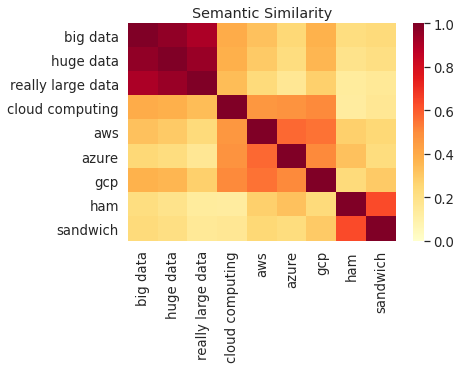

In [41]:
embed_and_plot(words)

### Sentence similarity

In [45]:
sentences =['I am a physicist','I studied physics','I am a physician','I studied medicine']


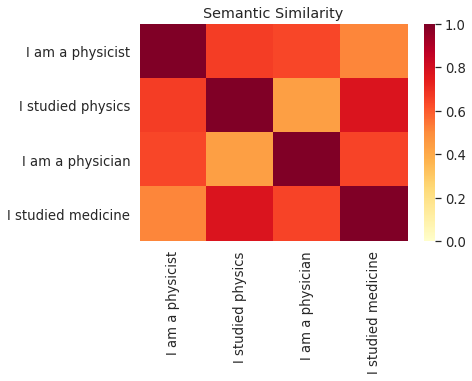

In [46]:
embed_and_plot(sentences)

## Semantic search on paragraphs
### Load document as list of paragraphs

In [22]:
with fitz.open(fname) as doc:
    blocks = []
    for page in doc:
        blocks += page.getText('blocks')

print(blocks)

[(100.13200378417969, 87.67097473144531, 511.31451416015625, 108.41552734375, 'TOP2VEC: DISTRIBUTED REPRESENTATIONS OF TOPICS', 0, 0), (240.24697875976562, 147.43089294433594, 371.75347900390625, 170.26512145996094, 'Dimo Angelov dimo.angelov@gmail.com', 1, 0), (277.2959899902344, 199.40899658203125, 334.7088928222656, 214.96270751953125, 'ABSTRACT', 2, 0), (107.86599731445312, 225.84356689453125, 504.30029296875, 368.75750732421875, 'Topic modeling is used for discovering latent semantic structure, usually referred to as topics, in a large collection of documents. The most widely used methods are Latent Dirichlet Allocation and Probabilistic Latent Semantic Analysis. Despite their popularity they have several weaknesses. In order to achieve optimal results they often require the number of topics to be known, custom stop-word lists, stemming, and lemmatization. Additionally these methods rely on bag-of-words representation of documents which ignore the ordering and semantics of words. 

In [23]:
paragraphs=[]
to_append=""
# to prevent short blocks like titles from taking up 1 paragraph, set a threshold below which they are merged with the following block
len_threshold=30
for block in blocks:
    to_append+=fix_text(block[4])+" "
    if len(to_append)>len_threshold:
        paragraphs.append(to_append)
        to_append=""
paragraphs

['TOP2VEC: DISTRIBUTED REPRESENTATIONS OF TOPICS ',
 'Dimo Angelov dimo.angelov@gmail.com ',
 'ABSTRACT Topic modeling is used for discovering latent semantic structure, usually referred to as topics, in a large collection of documents. The most widely used methods are Latent Dirichlet Allocation and Probabilistic Latent Semantic Analysis. Despite their popularity they have several weaknesses. In order to achieve optimal results they often require the number of topics to be known, custom stop-word lists, stemming, and lemmatization. Additionally these methods rely on bag-of-words representation of documents which ignore the ordering and semantics of words. Distributed representations of documents and words have gained popularity due to their ability to capture semantics of words and documents. We present top2vec, which leverages joint document and word semantic embedding to find topic vectors. This model does not require stop-word lists, stemming or lemmatization, and it automatically 

In [34]:
paragraphs[3]

'1 Introduction The ability to organize, search and summarize a large volume of text is a ubiquitous problem in natural language processing (NLP). Topic modeling is often used when a large collection of text cannot be reasonably read and sorted through by a person. Given a corpus comprised of many texts, referred to as documents, a topic model will discover the latent semantic structure, or topics, present in the documents. Topics can then be used to find high level summaries of a large collection of documents, search for documents of interest, and group similar documents together. '

In [25]:
len(paragraphs)

205

### Embed and save
Create numerical embeddings for each paragraph and save them to disk for future reference.
Embeddings are 512-element numerical arrays.

In [26]:
for i in range(len(paragraphs)):
    print("Paragraph n.: ",i)
    directory = "./embeddings/"+fname+"/paragraph_" + str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)
    m=embed([paragraphs[i]])
    exported_m = tf.train.Checkpoint(v=tf.Variable(m))
    exported_m.f = tf.function(
        lambda  x: exported_m.v * x,
        input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])
    tf.saved_model.save(exported_m,directory)

Paragraph n.:  0
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_0/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_0/assets


Paragraph n.:  1
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_1/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_1/assets


Paragraph n.:  2
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_2/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_2/assets


Paragraph n.:  3
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_3/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_3/assets


Paragraph n.:  4
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_4/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_4/assets


Paragraph n.:  5
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_5/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_5/assets


Paragraph n.:  6
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_6/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_6/assets


Paragraph n.:  7
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_7/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_7/assets


Paragraph n.:  8
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_8/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_8/assets


Paragraph n.:  9
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_9/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_9/assets


Paragraph n.:  10
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_10/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_10/assets


Paragraph n.:  11
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_11/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_11/assets


Paragraph n.:  12
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_12/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_12/assets


Paragraph n.:  13
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_13/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_13/assets


Paragraph n.:  14
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_14/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_14/assets


Paragraph n.:  15
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_15/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_15/assets


Paragraph n.:  16
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_16/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_16/assets


Paragraph n.:  17
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_17/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_17/assets


Paragraph n.:  18
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_18/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_18/assets


Paragraph n.:  19
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_19/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_19/assets


Paragraph n.:  20
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_20/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_20/assets


Paragraph n.:  21
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_21/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_21/assets


Paragraph n.:  22
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_22/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_22/assets


Paragraph n.:  23
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_23/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_23/assets


Paragraph n.:  24
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_24/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_24/assets


Paragraph n.:  25
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_25/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_25/assets


Paragraph n.:  26
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_26/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_26/assets


Paragraph n.:  27
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_27/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_27/assets


Paragraph n.:  28
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_28/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_28/assets


Paragraph n.:  29
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_29/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_29/assets


Paragraph n.:  30
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_30/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_30/assets


Paragraph n.:  31
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_31/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_31/assets


Paragraph n.:  32
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_32/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_32/assets


Paragraph n.:  33
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_33/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_33/assets


Paragraph n.:  34
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_34/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_34/assets


Paragraph n.:  35
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_35/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_35/assets


Paragraph n.:  36
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_36/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_36/assets


Paragraph n.:  37
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_37/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_37/assets


Paragraph n.:  38
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_38/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_38/assets


Paragraph n.:  39
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_39/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_39/assets


Paragraph n.:  40
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_40/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_40/assets


Paragraph n.:  41
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_41/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_41/assets


Paragraph n.:  42
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_42/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_42/assets


Paragraph n.:  43
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_43/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_43/assets


Paragraph n.:  44
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_44/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_44/assets


Paragraph n.:  45
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_45/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_45/assets


Paragraph n.:  46
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_46/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_46/assets


Paragraph n.:  47
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_47/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_47/assets


Paragraph n.:  48
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_48/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_48/assets


Paragraph n.:  49
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_49/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_49/assets


Paragraph n.:  50
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_50/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_50/assets


Paragraph n.:  51
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_51/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_51/assets


Paragraph n.:  52
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_52/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_52/assets


Paragraph n.:  53
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_53/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_53/assets


Paragraph n.:  54
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_54/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_54/assets


Paragraph n.:  55
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_55/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_55/assets


Paragraph n.:  56
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_56/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_56/assets


Paragraph n.:  57
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_57/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_57/assets


Paragraph n.:  58
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_58/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_58/assets


Paragraph n.:  59
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_59/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_59/assets


Paragraph n.:  60
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_60/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_60/assets


Paragraph n.:  61
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_61/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_61/assets


Paragraph n.:  62
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_62/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_62/assets


Paragraph n.:  63
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_63/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_63/assets


Paragraph n.:  64
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_64/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_64/assets


Paragraph n.:  65
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_65/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_65/assets


Paragraph n.:  66
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_66/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_66/assets


Paragraph n.:  67
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_67/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_67/assets


Paragraph n.:  68
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_68/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_68/assets


Paragraph n.:  69
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_69/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_69/assets


Paragraph n.:  70
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_70/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_70/assets


Paragraph n.:  71
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_71/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_71/assets


Paragraph n.:  72
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_72/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_72/assets


Paragraph n.:  73
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_73/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_73/assets


Paragraph n.:  74
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_74/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_74/assets


Paragraph n.:  75
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_75/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_75/assets


Paragraph n.:  76
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_76/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_76/assets


Paragraph n.:  77
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_77/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_77/assets


Paragraph n.:  78
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_78/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_78/assets


Paragraph n.:  79
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_79/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_79/assets


Paragraph n.:  80
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_80/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_80/assets


Paragraph n.:  81
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_81/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_81/assets


Paragraph n.:  82
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_82/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_82/assets


Paragraph n.:  83
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_83/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_83/assets


Paragraph n.:  84
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_84/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_84/assets


Paragraph n.:  85
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_85/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_85/assets


Paragraph n.:  86
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_86/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_86/assets


Paragraph n.:  87
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_87/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_87/assets


Paragraph n.:  88
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_88/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_88/assets


Paragraph n.:  89
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_89/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_89/assets


Paragraph n.:  90
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_90/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_90/assets


Paragraph n.:  91
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_91/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_91/assets


Paragraph n.:  92
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_92/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_92/assets


Paragraph n.:  93
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_93/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_93/assets


Paragraph n.:  94
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_94/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_94/assets


Paragraph n.:  95
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_95/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_95/assets


Paragraph n.:  96
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_96/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_96/assets


Paragraph n.:  97
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_97/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_97/assets


Paragraph n.:  98
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_98/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_98/assets


Paragraph n.:  99
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_99/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_99/assets


Paragraph n.:  100
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_100/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_100/assets


Paragraph n.:  101
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_101/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_101/assets


Paragraph n.:  102
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_102/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_102/assets


Paragraph n.:  103
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_103/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_103/assets


Paragraph n.:  104
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_104/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_104/assets


Paragraph n.:  105
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_105/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_105/assets


Paragraph n.:  106
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_106/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_106/assets


Paragraph n.:  107
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_107/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_107/assets


Paragraph n.:  108
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_108/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_108/assets


Paragraph n.:  109
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_109/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_109/assets


Paragraph n.:  110
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_110/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_110/assets


Paragraph n.:  111
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_111/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_111/assets


Paragraph n.:  112
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_112/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_112/assets


Paragraph n.:  113
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_113/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_113/assets


Paragraph n.:  114
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_114/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_114/assets


Paragraph n.:  115
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_115/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_115/assets


Paragraph n.:  116
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_116/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_116/assets


Paragraph n.:  117
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_117/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_117/assets


Paragraph n.:  118
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_118/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_118/assets


Paragraph n.:  119
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_119/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_119/assets


Paragraph n.:  120
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_120/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_120/assets


Paragraph n.:  121
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_121/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_121/assets


Paragraph n.:  122
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_122/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_122/assets


Paragraph n.:  123
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_123/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_123/assets


Paragraph n.:  124
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_124/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_124/assets


Paragraph n.:  125
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_125/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_125/assets


Paragraph n.:  126
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_126/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_126/assets


Paragraph n.:  127
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_127/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_127/assets


Paragraph n.:  128
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_128/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_128/assets


Paragraph n.:  129
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_129/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_129/assets


Paragraph n.:  130
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_130/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_130/assets


Paragraph n.:  131
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_131/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_131/assets


Paragraph n.:  132
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_132/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_132/assets


Paragraph n.:  133
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_133/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_133/assets


Paragraph n.:  134
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_134/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_134/assets


Paragraph n.:  135
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_135/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_135/assets


Paragraph n.:  136
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_136/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_136/assets


Paragraph n.:  137
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_137/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_137/assets


Paragraph n.:  138
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_138/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_138/assets


Paragraph n.:  139
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_139/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_139/assets


Paragraph n.:  140
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_140/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_140/assets


Paragraph n.:  141
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_141/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_141/assets


Paragraph n.:  142
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_142/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_142/assets


Paragraph n.:  143
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_143/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_143/assets


Paragraph n.:  144
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_144/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_144/assets


Paragraph n.:  145
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_145/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_145/assets


Paragraph n.:  146
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_146/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_146/assets


Paragraph n.:  147
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_147/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_147/assets


Paragraph n.:  148
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_148/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_148/assets


Paragraph n.:  149
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_149/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_149/assets


Paragraph n.:  150
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_150/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_150/assets


Paragraph n.:  151
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_151/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_151/assets


Paragraph n.:  152
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_152/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_152/assets


Paragraph n.:  153
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_153/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_153/assets


Paragraph n.:  154
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_154/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_154/assets


Paragraph n.:  155
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_155/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_155/assets


Paragraph n.:  156
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_156/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_156/assets


Paragraph n.:  157
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_157/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_157/assets


Paragraph n.:  158
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_158/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_158/assets


Paragraph n.:  159
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_159/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_159/assets


Paragraph n.:  160
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_160/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_160/assets


Paragraph n.:  161
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_161/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_161/assets


Paragraph n.:  162
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_162/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_162/assets


Paragraph n.:  163
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_163/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_163/assets


Paragraph n.:  164
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_164/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_164/assets


Paragraph n.:  165
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_165/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_165/assets


Paragraph n.:  166
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_166/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_166/assets


Paragraph n.:  167
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_167/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_167/assets


Paragraph n.:  168
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_168/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_168/assets


Paragraph n.:  169
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_169/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_169/assets


Paragraph n.:  170
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_170/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_170/assets


Paragraph n.:  171
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_171/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_171/assets


Paragraph n.:  172
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_172/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_172/assets


Paragraph n.:  173
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_173/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_173/assets


Paragraph n.:  174
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_174/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_174/assets


Paragraph n.:  175
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_175/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_175/assets


Paragraph n.:  176
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_176/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_176/assets


Paragraph n.:  177
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_177/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_177/assets


Paragraph n.:  178
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_178/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_178/assets


Paragraph n.:  179
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_179/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_179/assets


Paragraph n.:  180
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_180/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_180/assets


Paragraph n.:  181
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_181/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_181/assets


Paragraph n.:  182
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_182/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_182/assets


Paragraph n.:  183
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_183/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_183/assets


Paragraph n.:  184
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_184/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_184/assets


Paragraph n.:  185
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_185/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_185/assets


Paragraph n.:  186
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_186/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_186/assets


Paragraph n.:  187
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_187/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_187/assets


Paragraph n.:  188
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_188/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_188/assets


Paragraph n.:  189
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_189/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_189/assets


Paragraph n.:  190
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_190/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_190/assets


Paragraph n.:  191
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_191/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_191/assets


Paragraph n.:  192
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_192/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_192/assets


Paragraph n.:  193
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_193/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_193/assets


Paragraph n.:  194
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_194/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_194/assets


Paragraph n.:  195
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_195/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_195/assets


Paragraph n.:  196
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_196/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_196/assets


Paragraph n.:  197
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_197/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_197/assets


Paragraph n.:  198
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_198/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_198/assets


Paragraph n.:  199
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_199/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_199/assets


Paragraph n.:  200
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_200/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_200/assets


Paragraph n.:  201
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_201/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_201/assets


Paragraph n.:  202
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_202/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_202/assets


Paragraph n.:  203
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_203/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_203/assets


Paragraph n.:  204
INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_204/assets


INFO:tensorflow:Assets written to: ./embeddings/top2vec.pdf/paragraph_204/assets


### Read saved embeddings 

In [27]:
embeddings = np.zeros((1,512))
for i in range(len(paragraphs)):
    directory = "./embeddings/"+fname+"/paragraph_" + str(i)
    if os.path.exists(directory):
        print(directory)
        imported_m = tf.saved_model.load(directory)
        a= imported_m.v.numpy()
        #print(a)
        #exec(f'load{i} = a')
        embeddings=np.concatenate([embeddings,a])


./embeddings/top2vec.pdf/paragraph_0
./embeddings/top2vec.pdf/paragraph_1
./embeddings/top2vec.pdf/paragraph_2
./embeddings/top2vec.pdf/paragraph_3
./embeddings/top2vec.pdf/paragraph_4
./embeddings/top2vec.pdf/paragraph_5
./embeddings/top2vec.pdf/paragraph_6
./embeddings/top2vec.pdf/paragraph_7
./embeddings/top2vec.pdf/paragraph_8
./embeddings/top2vec.pdf/paragraph_9
./embeddings/top2vec.pdf/paragraph_10
./embeddings/top2vec.pdf/paragraph_11
./embeddings/top2vec.pdf/paragraph_12
./embeddings/top2vec.pdf/paragraph_13
./embeddings/top2vec.pdf/paragraph_14
./embeddings/top2vec.pdf/paragraph_15
./embeddings/top2vec.pdf/paragraph_16
./embeddings/top2vec.pdf/paragraph_17
./embeddings/top2vec.pdf/paragraph_18
./embeddings/top2vec.pdf/paragraph_19
./embeddings/top2vec.pdf/paragraph_20
./embeddings/top2vec.pdf/paragraph_21
./embeddings/top2vec.pdf/paragraph_22
./embeddings/top2vec.pdf/paragraph_23
./embeddings/top2vec.pdf/paragraph_24
./embeddings/top2vec.pdf/paragraph_25
./embeddings/top2vec.p

In [28]:
embeddings.shape

(206, 512)

There are as many embeddings as there are paragraphs and each is a 512-element array. The first one is empty, so drop it.

In [29]:
embeddings=embeddings[1:len(embeddings)]
embeddings.shape

(205, 512)

Embeddings can be seen as a database of paragraphs. On a large scale system, you should consider storing them permanently in BigQuery or other mechanism that supports arrays as native types.

In [30]:
embeddings

array([[ 0.00566422, -0.02935146,  0.06120373, ...,  0.04055705,
        -0.04339721,  0.02022251],
       [-0.0429877 ,  0.00689969,  0.03611137, ..., -0.00834908,
        -0.07034817, -0.03555313],
       [ 0.05260128,  0.03511225,  0.01449342, ...,  0.05155471,
         0.00496395, -0.04210687],
       ...,
       [-0.03725477,  0.01147169, -0.01395804, ...,  0.06737421,
        -0.00183064, -0.0466091 ],
       [-0.04363855,  0.0078327 , -0.05713132, ...,  0.09173808,
        -0.08570419, -0.06860624],
       [-0.03068276,  0.04709442, -0.01252738, ...,  0.0087611 ,
        -0.05826507, -0.04110563]])

### Define a search function
Search will rank documents in order of similarity as defined by linear kernel $x^{T}y$

In [31]:
def SearchDocument(query):
    q =[query]
    
    # Embed the query 
    Q_embedded =embed(q)
    
    # Calculate the similarity. Linear kernel is a generalization of xTx
    linear_similarities = linear_kernel(Q_embedded, embeddings).flatten() 
    
    #Sort top 10 indexes by similarity score
    top_index_doc = linear_similarities.argsort()[:-11:-1]
    linear_similarities.sort()
    
    a = pd.DataFrame()
    for i,index in enumerate(top_index_doc):
        a.loc[i,'index'] = str(index)
        # Read paragraph with relevant index
        a.loc[i,'Paragraph'] = paragraphs[index] 
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a


### Search 
Search for similar strings with different meanings and compare the results

In [32]:
SearchDocument('dirichlet allocation')

,index,Paragraph,Score
0,10,Probabilistic Latent Semantic Analysis (PLSA) ...,0.501231
1,8,The most widely used topic modeling method is ...,0.396057
2,185,[4] S. Syed and M. Spruit. Full-text or abstra...,0.374829
3,14,The authors of the LDA paper explicitly state:...,0.369781
4,186,"[5] Kai Yang, Yi Cai, Zhenhong Chen, Ho-fung L...",0.351286
5,0,TOP2VEC: DISTRIBUTED REPRESENTATIONS OF TOPICS,0.346380
6,182,"23 References [1] David M. Blei, Andrew Y. Ng,...",0.326645
7,27,The greatest difference between top2vec and pr...,0.325732
8,42,In order find the dense areas of documents in ...,0.310141
9,44,Dimension reduction allows for dense clusters ...,0.289434


In [33]:
SearchDocument('resources allocation')

,index,Paragraph,Score
0,61,The topic and document vectors allow for the s...,0.174717
1,62,An advantage of the topic vectors and the cont...,0.159371
2,29,"In order to be able to extract topics, jointly...",0.157110
3,97,"4 Discussion We have described top2vec, an uns...",0.144884
4,41,"In the semantic space, a dense area of documen...",0.142814
5,47,The goal of density based clustering is to fin...,0.129333
6,25,In contrast to traditional BOW topic modeling ...,0.129004
7,23,A semantic space is a spatial representation i...,0.124824
8,40,2.2 Find Number of Topics The semantic embeddi...,0.122632
9,44,Dimension reduction allows for dense clusters ...,0.114138


The search function has no reference and only 1 document to search on - it will return something from that document. However, it will have a lower similarity score to the query if the topic is less relevant than the previous one.

## Summarization
Use a pre-trained summarizer with SciBert

In [6]:
with fitz.open(fname) as doc:
    text = ""
    for page in doc:
        text += fix_text(page.getText())

print(text)

TOP2VEC: DISTRIBUTED REPRESENTATIONS OF TOPICS
Dimo Angelov
dimo.angelov@gmail.com
ABSTRACT
Topic modeling is used for discovering latent semantic structure, usually referred to as topics, in a
large collection of documents. The most widely used methods are Latent Dirichlet Allocation and
Probabilistic Latent Semantic Analysis. Despite their popularity they have several weaknesses. In
order to achieve optimal results they often require the number of topics to be known, custom stop-word
lists, stemming, and lemmatization. Additionally these methods rely on bag-of-words representation
of documents which ignore the ordering and semantics of words. Distributed representations of
documents and words have gained popularity due to their ability to capture semantics of words and
documents. We present top2vec, which leverages joint document and word semantic embedding
to find topic vectors. This model does not require stop-word lists, stemming or lemmatization, and
it automatically finds the nu

In [7]:
SUMMARY_RATIO = 0.05

Note that this is an extractive summarizer - it returns sentences from the document that are considered most relevant to the topic being discussed.  
Abstractive summarizers will construct new sentences - but are also much more complex.

In [8]:
model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

In [9]:
summary=model(text, SUMMARY_RATIO)

In [10]:
print(summary)

TOP2VEC: DISTRIBUTED REPRESENTATIONS OF TOPICS
Dimo Angelov
dimo.angelov@gmail.com
ABSTRACT
Topic modeling is used for discovering latent semantic structure, usually referred to as topics, in a
large collection of documents. Distributed representations of
documents and words have gained popularity due to their ability to capture semantics of words and
documents. We argue that the semantic space itself is a continuous
representation of topics, in which each point is a different topic best summarized by its nearest words. We use this assumption to propose top2vec, a distributed topic vector which is calculated from
dense areas of document vectors. This is due to the joint document and word embedding learning task, which is to predict
which words are most indicative of a document, which necessitates documents, and therefore topic vectors, to be closest
to their most informative words. The key insight into how doc2vec and word2vec learn these vectors is understanding how the prediction tas